In [3]:
import json
import os
import utils
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.spatial import Delaunay

f = open("export/jsons/20220829_174839/166178812217317200.json")
data = json.load(f)
gtruth = list()
glabels = list()
out = list()
outlabels = list()

temp = np.asarray(data['output']['label'])

for i in range(0, temp.size):
    gtruth += [temp[i]['bbox_3d']]
    glabels += [temp[i]['label_3d']]

temp = np.asarray(data['output']['inference'])

for i in range(0, temp.size):
    out += [temp[i]['bbox_3d']]
    outlabels += [temp[i]['label_3d']]

for bb in gtruth:
    bb[3], bb[4] = bb[4], bb[3]

[37.434940087994946,
 -2.5322737935382804,
 -0.7439064549037389,
 4.001514488220212,
 1.393621064186096,
 1.870611171722412,
 3.027573757546461]

In [8]:
points = utils.load_point_clouds("objdet/1661788122173172000.pcd")
bboxes = np.asarray(gtruth)

if len(bboxes != 0):
    corners3d = utils.boxes_to_corners_3d(bboxes)
    points_flag = utils.is_within_3d_box(points, corners3d)

    points_is_within_3d_box = []
    for i in range(len(points_flag)):
        p = points[points_flag[i]]
        if len(p)>0:
            points_is_within_3d_box.append(p)
            box = bboxes[i]
            points_canonical, box_canonical = utils.points_to_canonical(p, box)
            pts_name = 'partials/gtruth_pts'+str(i)
            box_name = 'partials/gtruth_box'+str(i)
            if (os.path.exists('partials') == False):
                os.makedirs('partials')
            utils.write_points(points_canonical, pts_name)
            utils.write_bboxes(box_canonical, box_name)
            utils.write_bboxes(corners3d, 'output/gtruth_bboxes')

In [9]:
bboxes = np.asarray(out)

if len(bboxes != 0):
    corners3d = utils.boxes_to_corners_3d(bboxes)
    points_flag = utils.is_within_3d_box(points, corners3d)

    points_is_within_3d_box = []
    for i in range(len(points_flag)):
        p = points[points_flag[i]]
        if len(p)>0:
            points_is_within_3d_box.append(p)
            box = bboxes[i]
            points_canonical, box_canonical = utils.points_to_canonical(p, box)
            pts_name = 'partials/out_pts'+str(i)
            box_name = 'partials/out_box'+str(i)
            if (os.path.exists('partials') == False):
                os.makedirs('partials')
            utils.write_points(points_canonical, pts_name)
            utils.write_bboxes(box_canonical, box_name)
            utils.write_bboxes(corners3d, 'output/out_bboxes')

### Visualize Data

In [11]:
def visual_right_scale(pos, ax):
    max_range = np.array([pos[:, 0].max()-pos[:, 0].min(),
                          pos[:, 1].max()-pos[:, 1].min(),
                          pos[:, 2].max()-pos[:, 2].min()]).max() / 2.0

    mid_x = (pos[:, 0].max()+pos[:, 0].min()) * 0.5
    mid_y = (pos[:, 1].max()+pos[:, 1].min()) * 0.5
    mid_z = (pos[:, 2].max()+pos[:, 2].min()) * 0.5

    # make scale look equal
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)


def visualize_3d_boxes(corners3d, ax):
    '''
    corners3d: (N, 8, 3)
    '''
    for n in range(corners3d.shape[0]):
        b = corners3d[n]  # (8, 3)

        for k in range(0, 4):
            i, j = k, (k + 1) % 4
            ax.plot([b[i, 0], b[j, 0]], [b[i, 1], b[j, 1]], [b[i, 2], b[j, 2]],
                    color='r')

            i, j = k + 4, (k + 1) % 4 + 4
            ax.plot([b[i, 0], b[j, 0]], [b[i, 1], b[j, 1]], [b[i, 2], b[j, 2]],
                    color='r')

            i, j = k, k + 4
            ax.plot([b[i, 0], b[j, 0]], [b[i, 1], b[j, 1]], [b[i, 2], b[j, 2]],
                    color='r')
    return

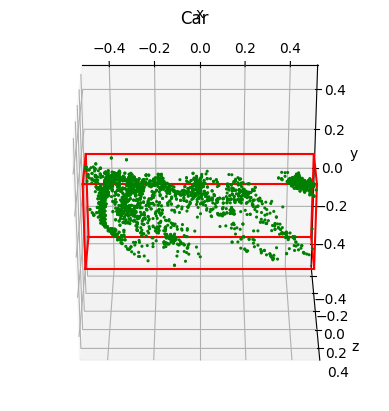

In [12]:
#%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pts = np.load('partials/out_pts4.npy').reshape(-1, 3)
bbox = np.load('partials/out_box4.npy').reshape(-1, 7)
corners3d = utils.boxes_to_corners_3d(bbox)

ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=5, c='g', lw=0, alpha=1)
visualize_3d_boxes(corners3d, ax)

visual_right_scale(corners3d.reshape(-1, 3), ax)
ax.title.set_text("Car")
ax.view_init(elev=120., azim=-90)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### COPOD

In [14]:
from pyod.models.copod import COPOD

cars = np.load("output/outall.npy")

clf_name = 'COPOD'
clf = COPOD(contamination=0.01)
clf.fit(cars)

gtruth_outp = list()
out_outp = list()

if(os.path.isdir('partials')):
    for file in os.listdir('partials'):
        if file.startswith("gtruth_pts"):
            pts = np.load("partials/"+file).reshape(-1, 3)
            predict = clf.predict(pts)
            outliers = predict[np.where(predict==1)]
            gtruth_outp.append((outliers.size/predict.size)*100)

        elif file.startswith("out_pts"):
            pts = np.load("partials/"+file).reshape(-1, 3)
            predict = clf.predict(pts)
            outliers = predict[np.where(predict==1)]
            out_outp.append((outliers.size/predict.size)*100)

np.save("output/gtruth_predict.npy", gtruth_outp)
np.save("output/inference_predict.npy", out_outp)

In [15]:
print(gtruth_outp)
print(out_outp)

[0.09110233829334953, 1.4749262536873156, 0.3225806451612903, 0.0]
[0.0, 2.782608695652174, 0.5427408412483039, 0.0, 4.524539877300613, 0.0]


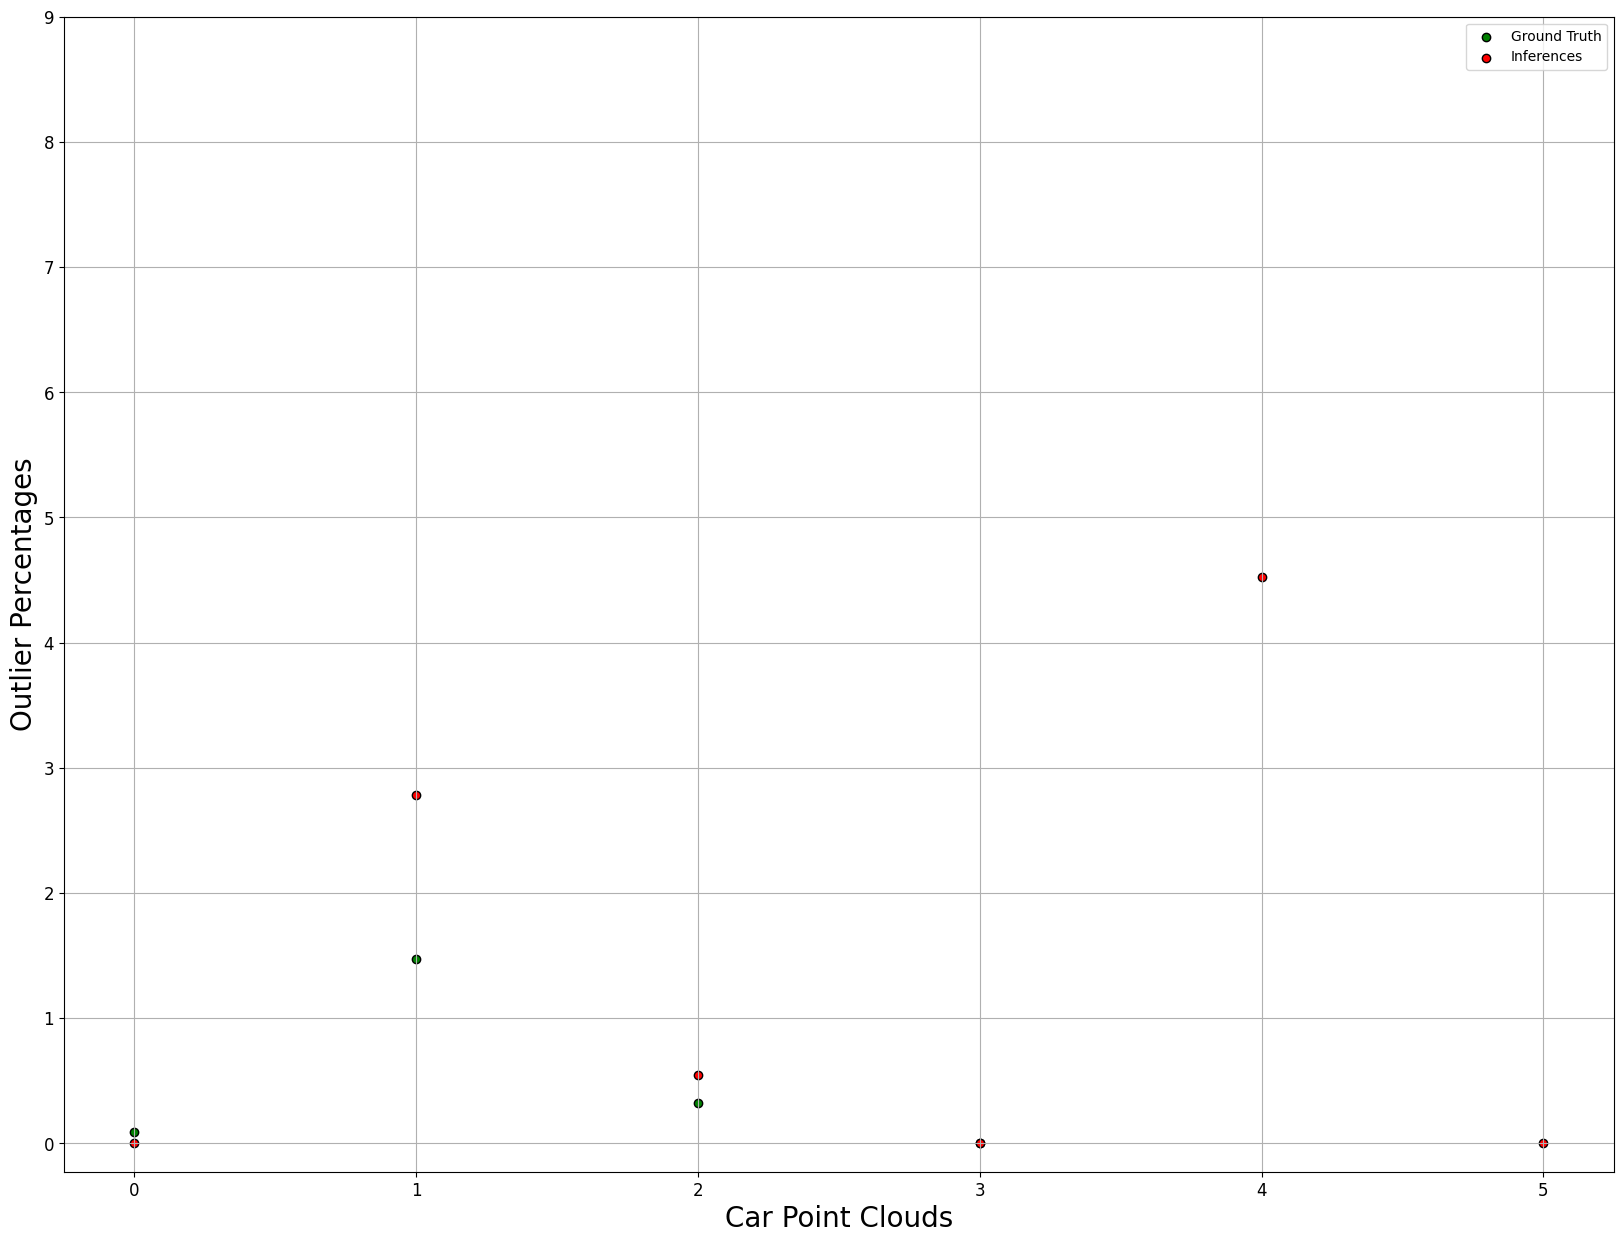

In [16]:
gtruth_outp = np.load("output/gtruth_predict.npy")
out_outp = np.load("output/inference_predict.npy")

X1 = np.arange(0, len(gtruth_outp))
X2 = np.arange(0, len(out_outp))

plt.rcParams['figure.figsize'] = [20, 15]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X1, gtruth_outp, edgecolor='black',color='green', label='Ground Truth')
ax.scatter(X2, out_outp, edgecolor='black',color='red', label='Inferences')
ax.set_yticks(np.arange(0, 10, step=1))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend()
ax.grid()
ax.set_ylabel('Outlier Percentages', fontsize=20)
ax.set_xlabel('Car Point Clouds', fontsize=20)
plt.show()

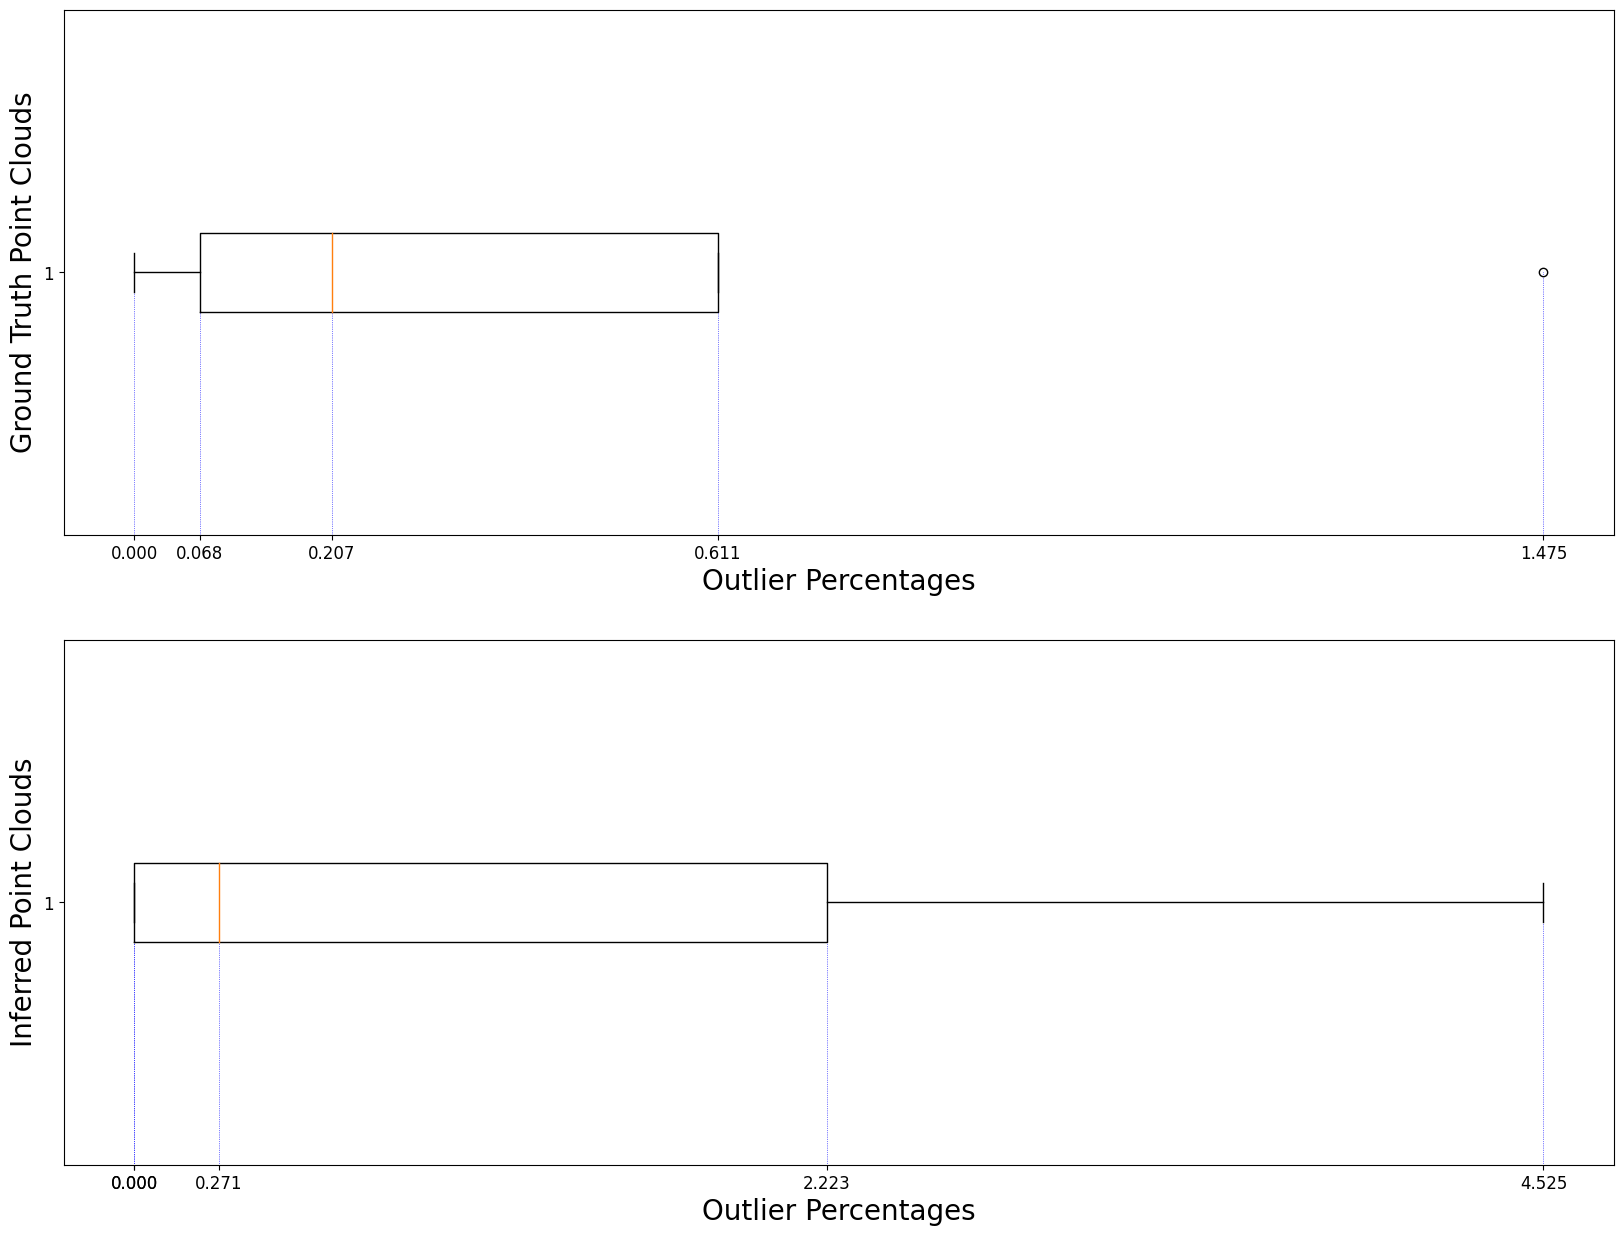

In [17]:
fig, ax = plt.subplots(2, figsize=(20, 15))

ax[0].boxplot(gtruth_outp, vert=False, manage_ticks=True)
ax[0].set_xlabel('Outlier Percentages', fontsize=20)
ax[0].set_yticks([1])
ax[0].set_ylabel('Ground Truth Point Clouds', fontsize=20)

quantiles = np.percentile(gtruth_outp, [0, 25, 50, 75, 100])
ax[0].vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.5, zorder=0)
ax[0].set_ylim(0.5, 1.5)
ax[0].set_xticks(quantiles)
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)

####################

ax[1].boxplot(out_outp, vert=False, manage_ticks=True)
ax[1].set_xlabel('Outlier Percentages', fontsize=20)
ax[1].set_yticks([1])
ax[1].set_ylabel('Inferred Point Clouds', fontsize=20)

quantiles = np.percentile(out_outp, [0, 25, 50, 75, 100])
ax[1].vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='b', ls=':', lw=0.5, zorder=0)
ax[1].set_ylim(0.5, 1.5)
ax[1].set_xticks(quantiles)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)

plt.show()

In [18]:
print("gtruth_outp:")
print("Sample Size:" + str(len(gtruth_outp)))
print("Quartiles:" + str(np.percentile(gtruth_outp, [0, 25, 50, 75, 100])))
print("Standard Deviation:" + str(np.std(gtruth_outp)))
print("Variance:" + str(np.var(gtruth_outp)))
print("\n")
print("out_outp:")
print("Sample Size:" + str(len(out_outp)))
print("Quartiles:" + str(np.percentile(out_outp, [0, 25, 50, 75, 100])))
print("Standard Deviation:" + str(np.std(out_outp)))
print("Variance:" + str(np.var(out_outp)))

gtruth_outp:
Sample Size:4
Quartiles:[0.         0.06832675 0.20684149 0.61066705 1.47492625]
Standard Deviation:0.5907736770195524
Variance:0.3490135374592025


out_outp:
Sample Size:6
Quartiles:[0.         0.         0.27137042 2.22264173 4.52453988]
Standard Deviation:1.7435028234672865
Variance:3.0398020954384
